In [27]:
import qmcpy as qp
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import cProfile
import pstats

In [28]:
def natural(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def natural_process(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural_process")
    points = l.gen_samples(num_ports) 
    return points
def mps(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def mps_process(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps_process",is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def linear(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def linear_process(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear_process")
    points = l.gen_samples(num_ports) 
    return points

In [29]:
trials = 1
d_list = [25, 100, 200, 300]
n = 10
data = {'index':d_list}
frame = pd.DataFrame(data)
frame = frame.set_index('index')
names = set()

#list contiants the function and a string of its name
run_list = [(natural, "natural"),(natural_process,"natural process"),(linear, "linear"),(linear_process,"linear process"),(mps,"mps"),(mps_process,"mps process")]

for method,method_name in run_list:

    name = method_name.split(" ")

    names.add(name[0])

    times = []
    
    for d in d_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(d, 2 ** n)
        profiler.disable()
        
        stats = pstats.Stats(profiler)
            
        process_time = stats.total_tt

        print(f'Process time {process_time} method name {method_name}')
        times.append(process_time)
        
    frame[method_name] = times        


names = list(names)     
print(frame)   


Process time 0.015277300000000006 method name natural
Process time 0.018411399999999994 method name natural
Process time 0.0265709 method name natural
Process time 0.0386504 method name natural
Process time 1.7074766 method name natural process
Process time 1.603158 method name natural process
Process time 1.6139604 method name natural process
Process time 1.5868590000000007 method name natural process
Process time 0.0036890999999999994 method name linear
Process time 0.009343900000000002 method name linear
Process time 0.0190191 method name linear
Process time 0.028445500000000026 method name linear
Process time 0.0033170999999999995 method name linear process
Process time 0.009306100000000001 method name linear process
Process time 0.019154300000000016 method name linear process
Process time 0.028049700000000007 method name linear process
Process time 0.020124800000000016 method name mps
Process time 0.022267300000000007 method name mps
Process time 0.02750550000000001 method name mp

In [30]:
comparse= [('natural', 'natural process'),('mps', 'mps process'),('linear', 'linear process')]



def speed_up_cal(data_frame, compare_list, dimension_list):
    result = []
    for seq,pro in compare_list:
        result = []
        for x in dimension_list:
            a = data_frame[seq][x]
            b = data_frame[pro][x]
            result.append(a/b)
        data_frame[seq + " speed-up"] = result


speed_up_cal(frame, comparse, d_list)

print(frame)





        natural  natural process    linear  linear process       mps  \
index                                                                  
25     0.015277         1.707477  0.003689        0.003317  0.020125   
100    0.018411         1.603158  0.009344        0.009306  0.022267   
200    0.026571         1.613960  0.019019        0.019154  0.027506   
300    0.038650         1.586859  0.028446        0.028050  0.036880   

       mps process  natural speed-up  mps speed-up  linear speed-up  
index                                                                
25        1.514666          0.008947      0.013287         1.112146  
100       1.281533          0.011484      0.017376         1.004062  
200       1.341948          0.016463      0.020497         0.992942  
300       1.402276          0.024357      0.026300         1.014111  


[0.0089473  0.01148446 0.01646317 0.02435654]


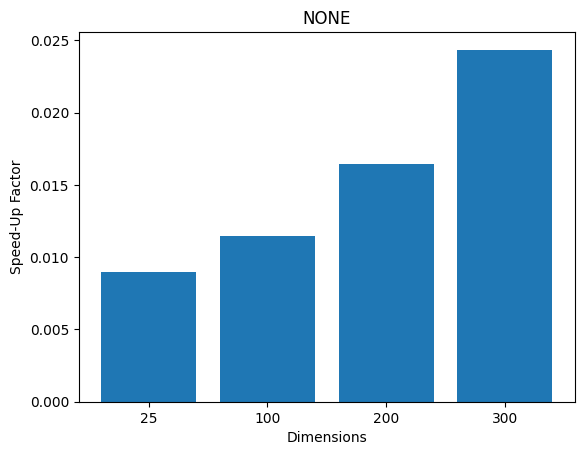

In [31]:

x = lambda array: [str(x) for x in array]

y_axis = frame["natural speed-up"].to_numpy()
print(y_axis)
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('NONE')
plt.show()

[1.11214615 1.00406185 0.99294153 1.01411067]


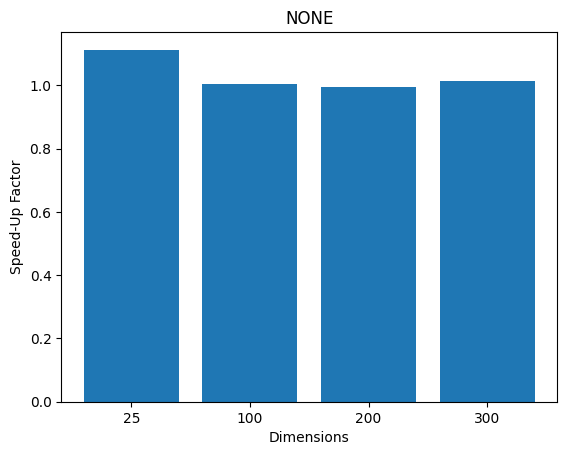

In [32]:
x = lambda array: [str(x) for x in array]

y_axis = frame["linear speed-up"].to_numpy()
print(y_axis)
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('NONE')
plt.show()

[0.01328662 0.01737551 0.0204967  0.02630016]


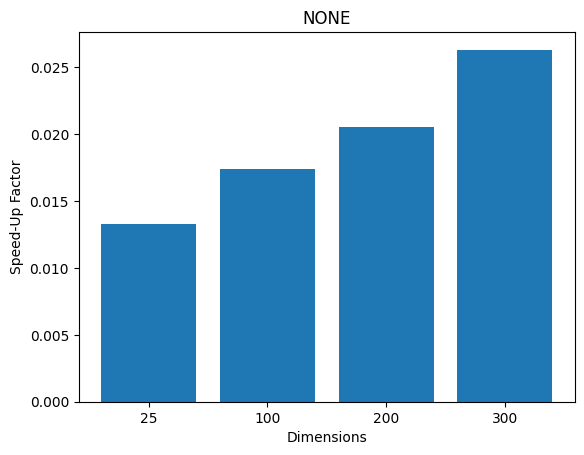

In [33]:
x = lambda array: [str(x) for x in array]

y_axis = frame["mps speed-up"].to_numpy()
print(y_axis)
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('NONE')
plt.show()

In [41]:
p_list = [x for x in range(10, 1_000, 100)]
dimension = 100
trials = 1
records = {'index':p_list}
frame2 = pd.DataFrame(records)
frame2 = frame2.set_index('index')
names = set()

for method, method_name in run_list:
    name = method_name.split(" ")

    names.add(name[0])


    times = []
    
    for p in p_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(d, p)
        profiler.disable()
    
        stats = pstats.Stats(profiler)
        
        process_time = stats.total_tt

        # print(f'Process time {process_time} method name {method_name}')
        times.append(process_time)
    
    frame2[method_name] = times        


names = list(names)     

In [42]:
print(frame2)

        natural  natural process    linear  linear process       mps  \
index                                                                  
10     0.003801         1.060583  0.001449        0.001505  0.003245   
110    0.006508         1.216095  0.004016        0.003129  0.005526   
210    0.010050         1.251340  0.006109        0.005351  0.007954   
310    0.012905         1.296107  0.011270        0.011455  0.012893   
410    0.017582         1.297484  0.011509        0.012367  0.014988   
510    0.015311         1.380732  0.011361        0.011759  0.014696   
610    0.021300         1.461125  0.021514        0.022688  0.024664   
710    0.020922         1.462248  0.022852        0.022397  0.025253   
810    0.024009         1.457557  0.022647        0.023543  0.024524   
910    0.021616         1.465212  0.022725        0.026001  0.026714   

       mps process  
index               
10        1.036246  
110       1.195460  
210       1.300131  
310       1.396928  
410      

In [43]:
speed_up_cal(frame2,comparse, p_list)

In [44]:
print(frame2)

        natural  natural process    linear  linear process       mps  \
index                                                                  
10     0.003801         1.060583  0.001449        0.001505  0.003245   
110    0.006508         1.216095  0.004016        0.003129  0.005526   
210    0.010050         1.251340  0.006109        0.005351  0.007954   
310    0.012905         1.296107  0.011270        0.011455  0.012893   
410    0.017582         1.297484  0.011509        0.012367  0.014988   
510    0.015311         1.380732  0.011361        0.011759  0.014696   
610    0.021300         1.461125  0.021514        0.022688  0.024664   
710    0.020922         1.462248  0.022852        0.022397  0.025253   
810    0.024009         1.457557  0.022647        0.023543  0.024524   
910    0.021616         1.465212  0.022725        0.026001  0.026714   

       mps process  natural speed-up  mps speed-up  linear speed-up  
index                                                            

[0.0035835  0.00535164 0.00803147 0.00995697 0.01355054 0.01108905
 0.0145776  0.01430804 0.01647215 0.01475309]


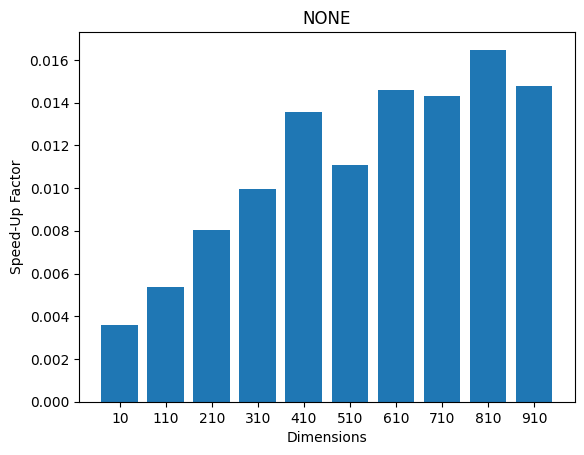

In [45]:
x = lambda array: [str(x) for x in array]

y_axis = frame2["natural speed-up"].to_numpy()
print(y_axis)
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('NONE')
plt.show()

[0.96252741 1.28329925 1.14159176 0.98387604 0.93063215 0.96610371
 0.94824949 1.02031048 0.9619294  0.87399525]


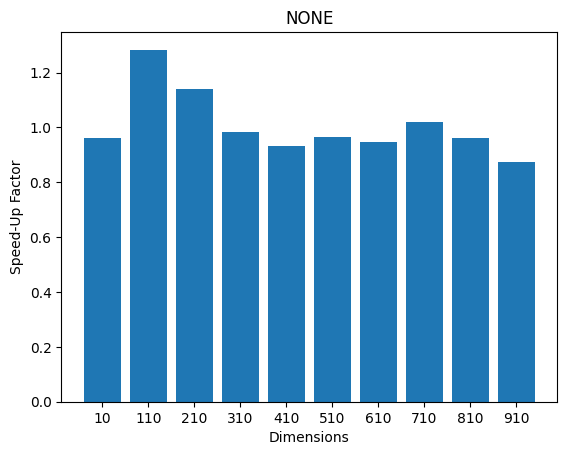

In [46]:
x = lambda array: [str(x) for x in array]

y_axis = frame2["linear speed-up"].to_numpy()
print(y_axis)
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('NONE')
plt.show()

[0.0031314  0.00462291 0.00611769 0.0092299  0.01072594 0.01052114
 0.01669152 0.01707326 0.01645741 0.01768054]


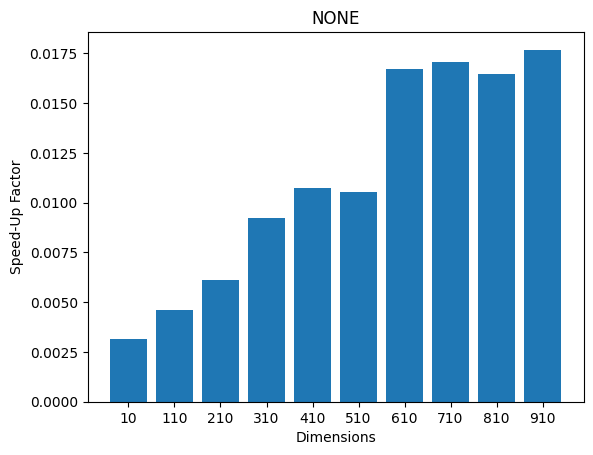

In [47]:
x = lambda array: [str(x) for x in array]

y_axis = frame2["mps speed-up"].to_numpy()
print(y_axis)
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('NONE')
plt.show()